## Data Preprocessing

In [3]:
# loading libraries
import librosa   #for audio processing
import librosa.display
import wave
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

c:\Users\meron\anaconda3\envs\meron_working\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
# loading scripts
sys.path.insert(1, '../scripts')
sys.path.append("..")
sys.path.append(".")

from data_cleaning import DataCleaner
from data_viz import Data_Viz
DC = DataCleaner("../logs/preprocessing_notebook.log")
DV = Data_Viz()

## Load metadata

In [5]:
# loading meta data
path = "../data/train"
output = "../data/train_new"

meta_data = DC.generate_metadata(path, output)
# adding duration column

DC.add_duration(meta_data)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()





,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.368
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.592
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.936
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.528
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.528


Spectogram

<function matplotlib.pyplot.show(close=None, block=None)>

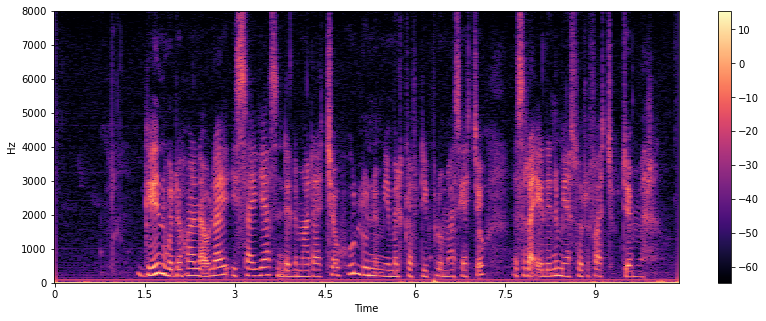

In [6]:
samples, sample_rate = librosa.load('../data/train/wav/tr_10_tr01010.wav', sr=None)
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show

## Standardize Sampling Rate

In [7]:
data =  wave.open('../data/train/wav/tr_10_tr01010.wav')
data.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=165888, comptype='NONE', compname='not compressed')

from the above we can see the framerate is 16000 , before standardization

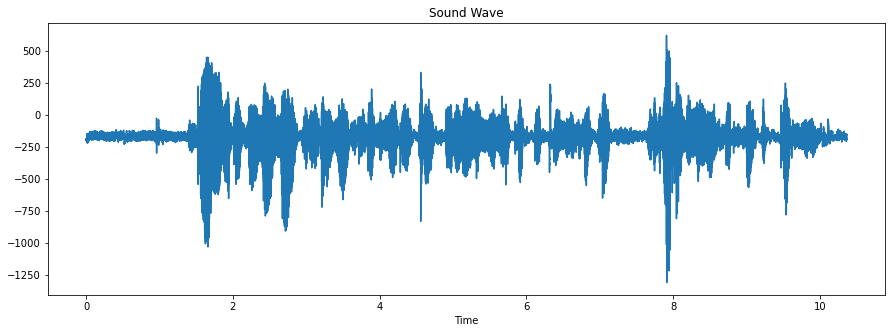

In [8]:
DV.visualize('../data/train/wav/tr_10_tr01010.wav')

In [9]:
DC.standardize(meta_data)

In [10]:
#checking after standandarization
data = wave.open('../data/train_new/tr_10_tr01010.wav')
data.getparams()

_wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=0, comptype='NONE', compname='not compressed')

**Observation**
- sample rates have been sucessfully standardized
- framrate = 44100


Resizing Audio Samples

In [11]:
# checking duration before resizing
selection.head()

,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.368
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.592
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.936
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.528
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.528


In [12]:
max_dur = DC.get_max_dur(meta_data)
DC.resize_pad_trunc(meta_data, max_dur)


maximum duration: 19.0


In [13]:
# checking duration after resizing
selection.head()

,Target,Feature,Output,Duration
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.368
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.592
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.936
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.528
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.528


Convert Mono to Stereo

In [14]:
# adding new column for channels count

meta_data= DC.channel_count(meta_data)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

,Target,Feature,Output,Duration,n_channel
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,10.368,1
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,14.592,1
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,7.936,1
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,6.528,1
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,6.528,1


In [15]:
# checking number of channels

meta_data["n_channel"].value_counts()

400    9889
1       986
Name: n_channel, dtype: int64

In [16]:
DC.make_stereo(meta_data)

In [17]:
#checking channel after conversion to stereo
meta_data= DC.channel_count(meta_data, True)
meta_data["n_channel"].value_counts()

400    9889
2       986
Name: n_channel, dtype: int64

**Observation**
- All the loaded audio samples are mono
- 400 is just a placeholder for missing audio files 
  because only a limited number of samples are taken for development
  This will not be present when the data is complete.

In [18]:
#checking
data =  wave.open('../data/train_new/tr_10_tr01010.wav')
print("the parameters are: ", data.getparams())
meta_data= DC.add_duration(meta_data, output= True)
meta_data= DC.channel_count(meta_data, output= True)
selection = meta_data[meta_data["Duration"] != 400]
selection.head()

the parameters are:  _wave_params(nchannels=2, sampwidth=2, framerate=16000, nframes=331776, comptype='NONE', compname='not compressed')


,Target,Feature,Output,Duration,n_channel
9,ግን ወደ ኋላው ላይ ኢሳያስ እንደ ልማ ዳቸው ሁሉን ም የ መልከ ፍ ዲፕሎ...,../data/train/wav/tr_10_tr01010.wav,../data/train_new/tr_10_tr01010.wav,20.736,2
99,አለቃ የጻፏቸው መጽሀፍት ውድ ና ጣፋጭ ከ መሆናቸው የተነሳ በ ህትመታቸው...,../data/train/wav/tr_100_tr01100.wav,../data/train_new/tr_100_tr01100.wav,29.184,2
100,በ ኮምፒውተር ሳይንስ ፎን ት ቴክኖሎጂ ለ ዶክትሬት ዲግሪ ጥናት እያደረጉ...,../data/train/wav/tr_101_tr02001.wav,../data/train_new/tr_101_tr02001.wav,15.872,2
101,የ ውሀው ዘርፍ ያለበት ን የ ፋይናንስ ችግር ለ መፍታት የ ውሀ ሀብት ል...,../data/train/wav/tr_102_tr02002.wav,../data/train_new/tr_102_tr02002.wav,13.056,2
102,የ መንገደኞች ማስተናገጃ ህንጻው በ ሰአት እስከ ሶስት ሺ ያህል መንገደኞ...,../data/train/wav/tr_103_tr02003.wav,../data/train_new/tr_103_tr02003.wav,13.056,2


Data Augumentatation

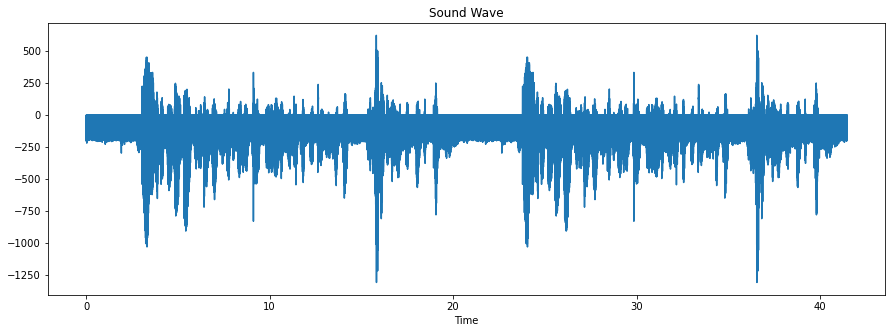

In [19]:
DV.visualize('../data/train_new/tr_10_tr01010.wav')

Data Augumentation | Time shift

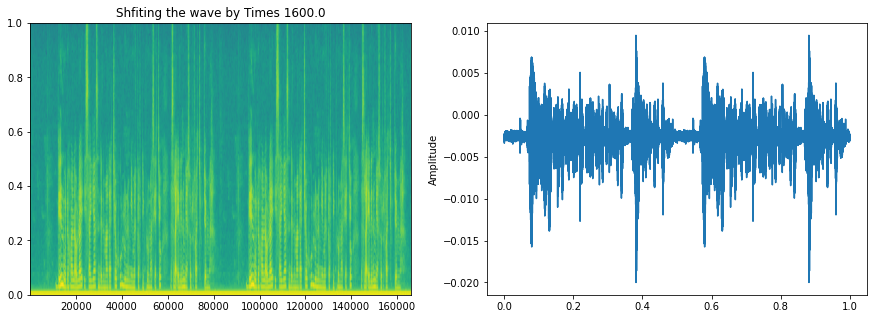

In [20]:
samples, sample_rate = librosa.load('../data/train_new/tr_10_tr01010.wav', sr=None)
DV.plot_spec(data=samples,sr=sample_rate)

Data Splitting 

In [21]:
df = DC.split(meta_data, 80, 2)
train = df[0]
test = df[1]
print(f"This is the training set: {train.shape}")
print (f"This is the test set: {test.shape}")

This is the training set: (789, 5)
This is the test set: (197, 5)


Save the preprocessed data

In [22]:
DC.meta_saver(train, "../data/train_meta.csv", 'csv')
DC.meta_saver(test, "../data/test_meta.csv", 'csv')


In [23]:
#load the data to check the csv file just created
test_df = DC.meta_loader("../data/test_meta.csv", 'csv')
test_df.head(3)

,Unnamed: 0,Target,Feature,Output,Duration,n_channel
0,789,አበራሽ የ ሰፈሩ ነገር ቆስቋሽ መሆኗ የ ታወቀ ነው,../data/train/wav/tr_10719_tr03136.wav,../data/train_new/tr_10719_tr03136.wav,9.984,2
1,790,ተድላ በልጅነ ቱ ቆረ በ,../data/train/wav/tr_10853_tr09127.wav,../data/train_new/tr_10853_tr09127.wav,4.864,2
2,791,ለ መሆኑ የ ቁንጅና መለኪያ ምንድነው,../data/train/wav/tr_10251_tr099093.wav,../data/train_new/tr_10251_tr099093.wav,6.144,2
